In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())


100%|██████████| 170M/170M [00:04<00:00, 39.7MB/s]


In [8]:
train = DataLoader(train_data, batch_size=32, shuffle=True)
test = DataLoader(test_data, batch_size=32)

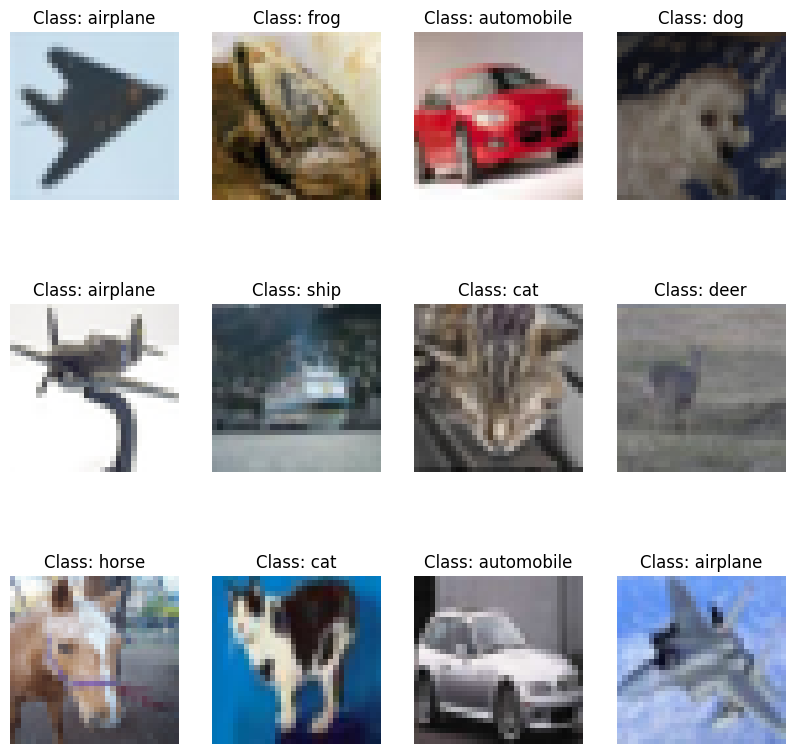

In [9]:
names = train_data.classes
image, label = next(iter(train))
plt.figure(figsize=(10, 10))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(image[i].permute(1, 2, 0))
    plt.title(f'Class: {names[label[i]]}')
    plt.axis('off')
plt.show()

In [10]:
import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [11]:
train_data.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [12]:
class CheckImage(nn.Module):
  def __init__(self):
    super().__init__()
    self.first = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),

    )
    self.second = nn.Sequential(
        nn.Flatten(),
        nn.Linear(32 * 16 * 16, 64),
        nn.ReLU(),
        nn.Linear(64, 10),
    )

  def forward(self, x):
      first_x = self.first(x)
      second_x = self.second(first_x)
      return second_x


In [13]:
class CheckImage2(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.first2 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # узнаём выходной размер автоматически
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 32, 32)  # поменяй 32x32 на свой размер входа
            out = self.first2(dummy)
            out_features = out.view(1, -1).size(1)

        self.second2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(out_features, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.first2(x)
        x = self.second2(x)
        return x


In [14]:
model = CheckImage().to(device)


In [15]:
model2 = CheckImage2().to(device)


In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [17]:
loss_fn2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=10, gamma=0.5)

In [18]:
for epoch in range(20):
  model.train()
  total_loss = 0
  for x_batch, y_batch in train:
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    y_pred_train = model(x_batch)

    loss = loss_fn(y_pred_train, y_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f'Эпоха: {epoch+1}, Потери: {total_loss}')

KeyboardInterrupt: 

In [20]:
for epoch in range(10):
    model2.train()
    total_loss = 0
    for x_batch, y_batch in train:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred_train = model2(x_batch)

        loss = loss_fn2(y_pred_train, y_batch)

        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()

        total_loss += loss.item()

    # обновляем lr
    scheduler.step()

    # печатаем текущий lr для контроля
    current_lr = optimizer2.param_groups[0]['lr']
    print(f'Эпоха: {epoch+1}, Потери: {total_loss:.4f}, LR: {current_lr:.6f}')

Эпоха: 1, Потери: 5.7267, LR: 0.000125
Эпоха: 2, Потери: 2.7951, LR: 0.000125
Эпоха: 3, Потери: 2.5774, LR: 0.000125
Эпоха: 4, Потери: 3.8187, LR: 0.000125
Эпоха: 5, Потери: 3.6961, LR: 0.000125
Эпоха: 6, Потери: 1.9898, LR: 0.000125
Эпоха: 7, Потери: 3.6488, LR: 0.000125
Эпоха: 8, Потери: 3.3785, LR: 0.000125
Эпоха: 9, Потери: 5.0462, LR: 0.000125
Эпоха: 10, Потери: 2.4039, LR: 0.000063


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
  for x_batch, y_batch in test:
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    y_pred_test = model(x_batch)
    predicted = torch.argmax(y_pred_test, dim=1)

    total += y_batch.size(0)
    correct += (predicted == y_batch).sum().item()

accuracy = 100 * correct / total
print(f'Точность на тестовых данных: {accuracy:.2f}%')

In [ ]:
model2.eval()
correct = 0
total = 0

with torch.no_grad():
  for x_batch, y_batch in test:
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    y_pred_test = model2(x_batch)
    predicted = torch.argmax(y_pred_test, dim=1)

    total += y_batch.size(0)
    correct += (predicted == y_batch).sum().item()

accuracy = 100 * correct / total
print(f'Точность на тестовых данных: {accuracy:.2f}%')

In [21]:
torch.save(model2.state_dict(), 'model.pth')

In [ ]:
train_data.classes

In [ ]:
test_max = nn.MaxPool2d(2)